In [1]:
# initial setup
try:
    # settings colab:
    import google.colab
    
    # si usan colab, deben cambiar el token de esta url
    #! mkdir -p ../data
    # los que usan colab deben modificar el token de esta url:
    #! wget -O ../data/properati_2017.csv https://raw.githubusercontent.com/Digital-House-DATA/ds_blend_students_2020/master/M2/CLASE_07_Pandas_2/Data/resultado-de-encuestas-2017-2018.csv?token=AA4GFHO3EKGWGILBCV4BISC6WR6B4
    
except ModuleNotFoundError:    
    # settings local:
    %run "common/base_setup.py"

Running command `conda list`... ok
pandas=1.0.3 already installed
matplotlib=2.2.2 already installed
bokeh=2.0.0 already installed
seaborn=0.10.0 already installed
ipywidgets=7.5.1 already installed
pytest=5.3.4 already installed
chardet=3.0.4 already installed
plotly=4.6.0 already installed
chart-studio=1.1.0 already installed
Running command `conda install --yes nodejs=13.13.0`... error
    
PackagesNotFoundError: The following packages are not available from current channels:

  - nodejs=13.13.0

Current channels:

  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.





## Carga Inicial del Dataset

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import re

from functools import partial

In [3]:
# low_memorybool, default True
# Internally process the file in chunks, resulting in lower memory use while parsing, 
# but possibly mixed type inference. To ensure no mixed types either set False, 
# or specify the type with the dtype parameter. 
# Note that the entire file is read into a single DataFrame regardless, 
# use the chunksize or iterator parameter to return the data in chunks. (Only valid with C parser).
data     = pd.read_csv("./data/properati_2017.csv", sep = ",", low_memory=False)
geonames = pd.read_csv("./data/AR.txt", sep = "\t", header=None, low_memory=False)
geonames = geonames[[0, 4, 5]]
geonames.rename(columns={0:'geonames_id', 4: 'gn_lat', 5: 'gn_lon'}, inplace=True)

In [4]:
# Utilidades
def drop_columns(df, columns):
    all_columns = set(df.columns)
    relevant_columns = all_columns.difference(set(columns))
    return df.loc[:, list(relevant_columns)]

def get_freq_na(df, zeros=False):
    na = df.isnull().sum(axis=0)
    na_percent = na / df.index.size
    result = pd.concat([na, na_percent], axis=1)
    result.columns = ['total', 'percent']
    return result if zeros else result[result['total'] > 0]

In [5]:
data.shape

(121220, 26)

In [6]:
data.columns

Index(['Unnamed: 0', 'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'rooms', 'expenses', 'properati_url', 'description', 'title',
       'image_thumbnail'],
      dtype='object')

In [7]:
data.dtypes

Unnamed: 0                      int64
operation                      object
property_type                  object
place_name                     object
place_with_parent_names        object
country_name                   object
state_name                     object
geonames_id                   float64
lat-lon                        object
lat                           float64
lon                           float64
price                         float64
currency                       object
price_aprox_local_currency    float64
price_aprox_usd               float64
surface_total_in_m2           float64
surface_covered_in_m2         float64
price_usd_per_m2              float64
price_per_m2                  float64
floor                         float64
rooms                         float64
expenses                      float64
properati_url                  object
description                    object
title                          object
image_thumbnail                object
dtype: objec

In [8]:
# categoricals
data["operation"]     = data["operation"].astype('category')
data["property_type"] = data["property_type"].astype('category')
data["country_name"]  = data["country_name"].astype('category')
data["state_name"]    = data["state_name"].astype('category')

In [9]:
# normalizations
regex = re.compile(r'\s+')
fformat = lambda x: regex.sub(' ', str(x)).strip().lower()
data['description'] = data['description'].apply(fformat)
data['title']       = data['title'].apply(fformat)

In [10]:
# Distribucion NA - Fase 0 Inicial
data   = data.dropna(how='all')
freqna = get_freq_na(data)
freqna

,total,percent
place_name,23,0.000190
geonames_id,18717,0.154405
lat-lon,51550,0.425260
lat,51550,0.425260
lon,51550,0.425260
price,20410,0.168372
currency,20411,0.168380
price_aprox_local_currency,20410,0.168372
price_aprox_usd,20410,0.168372
surface_total_in_m2,39328,0.324435


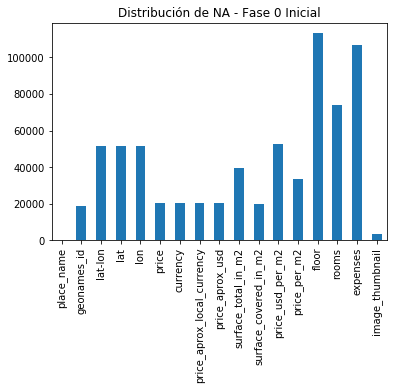

In [11]:
freqna['total'].plot.bar(title='Distribución de NA - Fase 0 Inicial')

## Tratamiento NA

In [12]:
# NA - place_name
na_place_name_mask = data["place_name"].isna()
na_place_name      = data[na_place_name_mask][["place_name", "place_with_parent_names"]]
na_place_name.drop_duplicates()

,place_name,place_with_parent_names
6489,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||


In [13]:
data['place_name'] = data['place_name'].fillna("Tigre").astype('category')

print("NA place_name (0): {0}".format(na_place_name_mask.sum()))
print("NA place_name (1): {0}".format(data["place_name"].isna().sum()))

NA place_name (0): 23
NA place_name (1): 0


In [14]:
# NA - lat/lon
na_lat_mask = data["lat"].isna()
na_lon_mask = data["lon"].isna()

data = pd.merge(data, geonames, on='geonames_id', how='left', left_index=True)
data['lat'] = data['lat'].fillna(data['gn_lat'])
data['lon'] = data['lon'].fillna(data['gn_lon'])
data = drop_columns(data, ['gn_lat', 'gn_lon'])

print("NA (lat, lon) (0): ({0}, {1})".format(na_lat_mask.sum(), na_lon_mask.sum()))
print("NA (lat, lon) (1): ({0}, {1})".format(data["lat"].isna().sum(), data["lon"].isna().sum()))

NA (lat, lon) (0): (51550, 51550)
NA (lat, lon) (1): (8346, 8346)


In [15]:
# NA - rooms
def get_rooms_from_text(text):
    if text is not np.nan:
        regex = r'([0-9]+)\s+(amb\s|amb\.|ambiente)'
        m = re.search(regex, text, re.I)
        if m is not None:
            return np.int(m.group(1))
    return np.nan

na_rooms_mask = data["rooms"].isna()

data['title_rooms']       = data['title'].map(get_rooms_from_text)
data['description_rooms'] = data['description'].map(get_rooms_from_text)

data['rooms'] = data['rooms'].fillna(data['title_rooms'])
data['rooms'] = data['rooms'].fillna(data['description_rooms'])
data = drop_columns(data, ['title_rooms', 'description_rooms'])

print("NA rooms (0): {0}".format(na_rooms_mask.sum()))
print("NA rooms (1): {0}".format(data["rooms"].isna().sum()))

NA rooms (0): 73830
NA rooms (1): 52531


In [16]:
# NA - floor
def get_floor_from_text(text):
    if text is not np.nan:
        if 'plante baja' in text:
            return 0
        regex = r'(1°|2°|3°|4°|5°|6°|2do|3er|primer|segundo|tercer)\spiso'
        m = re.search(regex, text, re.I)
        if m is not None:
            piso = m.group(1).lower()
            if piso in ['1°', 'primer']:
                return 1
            elif piso in ['2°', '2do', 'segundo']:
                return 2
            elif piso in ['3°', '3er', 'tercer']:
                return 3
            else:
                return np.int(piso.replace('°', ''))
    return np.nan

na_floor_mask = data["floor"].isna()

data['title_floor']       = data['title'].map(get_floor_from_text)
data['description_floor'] = data['description'].map(get_floor_from_text)

data['floor'] = data['floor'].fillna(data['title_floor'])
data['floor'] = data['floor'].fillna(data['description_floor'])
data = drop_columns(data, ['title_floor', 'description_floor'])

print("NA floor (0): {0}".format(na_floor_mask.sum()))
print("NA floor (1): {0}".format(data["floor"].isna().sum()))

NA floor (0): 113321
NA floor (1): 106563


In [17]:
def get_reg_from_text(text,reg):
    if text is not np.nan:
        regex = reg#r'parr'
        m = re.search(regex, text,re.IGNORECASE)
        if m is not None:
            return 1
    return 0

data['parrilla'] = data['description'].map(lambda x : get_reg_from_text(x,'parr|asador'))
print("Ocurrencias de parrillas encontradas: {0}".format(data['parrilla'].sum()))
data['quincho'] = data['description'].map(lambda x : get_reg_from_text(x,'quincho'))
print("Ocurrencias de quinchos  encontradas: {0}".format(data['quincho'].sum()))
data['balcon'] = data['description'].map(lambda x : get_reg_from_text(x,'balc'))
print("Ocurrencias de balcones encontrados: {0}".format(data['balcon'].sum()))
data['cochera'] = data['description'].map(lambda x : get_reg_from_text(x,'garag|coche'))
print("Ocurrencias de cocheras encontradas: {0}".format(data['cochera'].sum()))
data['patio'] = data['description'].map(lambda x : get_reg_from_text(x,'pati|jard'))
print("Ocurrencias de patios encontrados: {0}".format(data['patio'].sum()))
#existen muchos anuncios que utilizan el termino pileta en la descripcion para referirse a el fregadero
data['piscina'] = data['description'].map(lambda x : get_reg_from_text(x,'pisc'))
print("Ocurrencias de piscinas encontradas: {0}".format(data['piscina'].sum()))
#veamos la cantidad de amenities por unidad
data['amenities'] = data['parrilla'] + data['quincho'] + data['balcon'] + data['cochera'] + data['patio'] + data['piscina']


Ocurrencias de parrillas encontradas: 40895
Ocurrencias de quinchos  encontradas: 13094
Ocurrencias de balcones encontrados: 44719
Ocurrencias de cocheras encontradas: 51831
Ocurrencias de patios encontrados: 36278
Ocurrencias de piscinas encontradas: 15250


In [18]:
# NA - m2 cubiertos
def get_coveredm2_from_text(text):
    if text is not np.nan:
        regex = [
            r'(\d[0-9\.,]+)\s+m2\s+cub',
            r'metros\s+cubiertos\s*:?(\d[0-9\.,]+)',
            r'cubierta\s*:?(\d[0-9\.,]+)\s+m2',
        ]
        for pattern in regex:
            m = re.search(pattern, text, re.I)
            if m is not None:
                sup = m.group(1)
                sup = sup.replace('.', '').replace(',', '.')
                return np.nan if sup == '' else np.int(float(sup))
    return np.nan

na_surface_covered_mask = data["surface_covered_in_m2"].isna()

data['description_surface_m2_covered'] = data['description'].map(get_coveredm2_from_text)
data['surface_covered_in_m2']          = \
    data['surface_covered_in_m2'].fillna(data['description_surface_m2_covered'])
data = drop_columns(data, ['description_surface_m2_covered'])

print("NA surface_covered_in_m2 (0): {0}".format(na_surface_covered_mask.sum()))
print("NA surface_covered_in_m2 (1): {0}".format(data["surface_covered_in_m2"].isna().sum()))

NA surface_covered_in_m2 (0): 19907
NA surface_covered_in_m2 (1): 19554


In [19]:
# NA - m2 totales
def get_totalm2_from_text(text):
    if text is not np.nan:
        regex = [
            r'(\d[0-9\.,]+)\s+m2\s+tot',
            r'metros\s+totales\s*:?(\d[0-9\.,]+)',
        ]
        for pattern in regex:
            m = re.search(pattern, text, re.I)
            if m is not None:
                sup = m.group(1)
                sup = sup.replace('.', '').replace(',', '.')
                return np.nan if sup == '' else np.int(float(sup))
    return np.nan

na_surface_total_mask = data["surface_total_in_m2"].isna()

data['description_surface_m2_total'] = data['description'].map(get_totalm2_from_text)
data['surface_total_in_m2']          = \
    data['surface_total_in_m2'].fillna(data['description_surface_m2_total'])
data = drop_columns(data, ['description_surface_m2_total'])

print("NA surface_total_in_m2 (0): {0}".format(na_surface_total_mask.sum()))
print("NA surface_total_in_m2 (1): {0}".format(data["surface_total_in_m2"].isna().sum()))

NA surface_total_in_m2 (0): 39328
NA surface_total_in_m2 (1): 38989


In [20]:
# NA - price/currency
def get_price_from_title(text):
    regex = r'^\s*(\$|u\$d|usd)\s*([0-9\.,]+).+en\sventa'
    m = re.search(regex, text, re.I)
    if m is None:
        return np.nan, np.nan
    currency = 'ARS' if m.group(1) == '$' else 'USD'
    price    = np.float64(m.group(2).replace('.', '').replace(',', '.'))
    return currency, price

def get_price_from_description(text):
    if text is not np.nan:    
        regex = r'(vendo\scasa|valor\sde\sventa|valor:|vendo|valor|precio\ses\sde|precio\sde)\s+(\$|u\$d|usd)\s*([0-9\.,]+)'
        m = re.search(regex, text, re.I)
        if m is not None:
            currency = 'ARS' if m.group(2) == '$' else 'USD'
            price    = m.group(3).strip('.')
            if len(price) > 0:
                return currency, np.float64(price.replace('.', '').replace(',', '.'))
    return np.nan, np.nan

na_price_mask    = data["price"].isna()
na_currency_mask = data["currency"].isna()

data['title_currency'], data['title_price']             = zip(*data['title'].map(get_price_from_title))
data['description_currency'], data['description_price'] = \
    zip(*data['description'].map(get_price_from_description))

data['price'] = data['price'].fillna(data['title_price'])
data['price'] = data['price'].fillna(data['description_price'])
data['currency'] = data['currency'].fillna(data['title_currency'])
data['currency'] = data['currency'].fillna(data['description_currency'])

data = drop_columns(data, ['title_price', 'description_price', 'title_currency', 'description_currency'])

print("NA (price, currency) (0): ({0}, {1})".format(na_price_mask.sum(), na_currency_mask.sum()))
print("NA (price, currency) (1): ({0}, {1})".format(data["price"].isna().sum(), data["currency"].isna().sum()))

NA (price, currency) (0): (20410, 20411)
NA (price, currency) (1): (17464, 17465)


In [21]:
# Irrecuperables - No tiene sentido estimar todas las variables de precio y superficie
surface_cols = ['surface_total_in_m2', 'surface_covered_in_m2']
price_cols   = ['price', 'currency', 
                'price_aprox_local_currency', 'price_aprox_usd',
                'price_per_m2', 'price_usd_per_m2']

na_all_prices_mask   = data[price_cols].isna().all(axis=1)
na_all_surfaces_mask = data[surface_cols].isna().all(axis=1)
na_all_prices_and_surfaces_mask = na_all_prices_mask & na_all_surfaces_mask

print("NA prices: {0}".format(na_all_prices_mask.sum()))
print("NA surfaces: {0}".format(na_all_surfaces_mask.sum()))
print("NA prices+surfaces: {0}".format(na_all_prices_and_surfaces_mask.sum()))

data.dropna(subset=surface_cols+price_cols, how='all', inplace=True)

NA prices: 17464
NA surfaces: 12065
NA prices+surfaces: 4370


In [22]:
# dollar value
na_price_aprox_mask = data['price_aprox_usd'].isna() & data['price_aprox_local_currency'].isna()
price_aprox  = data.loc[~na_price_aprox_mask, ['price_aprox_usd', 'price_aprox_local_currency']]

na_price_aprox_gt0_mask = (price_aprox['price_aprox_usd'] > 0) & \
    (price_aprox['price_aprox_local_currency'] > 0)
price_aprox  = price_aprox[na_price_aprox_gt0_mask]

dollar_serie = price_aprox['price_aprox_local_currency'] / price_aprox['price_aprox_usd']
dollar = np.mean(dollar_serie)

print("Valor del Dolar: {0}".format(dollar))

Valor del Dolar: 17.644499988455582


In [23]:
def fill_prices_from_row(r, dollar):
    price_usd   = r.price_aprox_usd
    price_local = r.price_aprox_local_currency
    updated = False
    if (not pd.isnull(r.price)):
        if pd.isnull(price_usd):
            price_usd = r.price if r.currency == 'USD' else r.price / dollar
            updated = True
        if pd.isnull(price_local):
            price_local = r.price if r.currency == 'ARS' else r.price * dollar
            updated = True
    if updated:
        r.price_aprox_usd            = price_usd
        r.price_aprox_local_currency = price_local
    return r

na_price_mask                      = data["price"].isna()
na_price_aprox_usd_mask            = data["price_aprox_usd"].isna()
na_price_aprox_local_currency_mask = data["price_aprox_local_currency"].isna()
na_price_aprox = (na_price_aprox_usd_mask | na_price_aprox_local_currency_mask) & ~na_price_mask

data[na_price_aprox] = data[na_price_aprox].apply(partial(fill_prices_from_row, dollar=dollar), axis=1)

print("NA (price_usd, price_local) (0): ({0}, {1})".format(
    na_price_aprox_usd_mask.sum(), na_price_aprox_local_currency_mask.sum()))
print("NA (price_usd, price_local) (1): ({0}, {1})".format(
    data["price_aprox_usd"].isna().sum(), data["price_aprox_local_currency"].isna().sum()))

NA (price_usd, price_local) (0): (16040, 16040)
NA (price_usd, price_local) (1): (13094, 13094)


In [24]:
def fill_price_usd_m2_from_row(r, dollar):
    if not pd.isnull(r.surface_total_in_m2) and not pd.isnull(r.price_aprox_usd):
        if r.surface_total_in_m2 > 0:
            r.price_usd_per_m2 = r.price_aprox_usd / r.surface_total_in_m2
    elif not pd.isnull(r.price_per_m2):
        r.price_usd_per_m2 = r.price_per_m2 / dollar
    return r

def fill_price_m2_from_row(r, dollar):
    if not pd.isnull(r.price_usd_per_m2):
        r.price_per_m2 = r.price_usd_per_m2 * dollar
    return r

na_price_usd_per_m2_mask = data['price_usd_per_m2'].isna()
na_price_per_m2_mask     = data['price_per_m2'].isna()

data[na_price_usd_per_m2_mask] = data[na_price_usd_per_m2_mask].apply(
    partial(fill_price_usd_m2_from_row, dollar=dollar), axis=1)

data[na_price_per_m2_mask] = data[na_price_per_m2_mask].apply(
    partial(fill_price_m2_from_row, dollar=dollar), axis=1)

print("NA (price_usd_per_m2, price_per_m2) (0): ({0}, {1})".format(
    na_price_usd_per_m2_mask.sum(), na_price_per_m2_mask.sum()))
print("NA (price_usd_per_m2, price_per_m2) (1): ({0}, {1})".format(
    data["price_usd_per_m2"].isna().sum(), data["price_per_m2"].isna().sum()))

NA (price_usd_per_m2, price_per_m2) (0): (48233, 29192)
NA (price_usd_per_m2, price_per_m2) (1): (21482, 21482)


In [25]:
def fill_surface_total_m2_from_row(r):
    if r.price_usd_per_m2 > 0:
        r.surface_total_in_m2 = r.price_aprox_usd / r.price_usd_per_m2
    return r

na_surface_total_mask = data['surface_total_in_m2'].isna()

calc_surface_total_m2_mask = \
    data['price_aprox_usd'].notna() & \
    data['price_usd_per_m2'].notna() & \
    data['surface_total_in_m2'].isna()

data[calc_surface_total_m2_mask] = data[calc_surface_total_m2_mask].apply(
    fill_surface_total_m2_from_row, axis=1)

print("NA surface_total_in_m2 (0): {0}".format(na_surface_total_mask.sum()))
print("NA surface_total_in_m2 (1): {0}".format(data["surface_total_in_m2"].isna().sum()))

NA surface_total_in_m2 (0): 34619
NA surface_total_in_m2 (1): 10584


In [26]:
# Eliminamos columnas
data = drop_columns(data, ['expenses', 'lat-lon', 'image_thumbnail',
                           'place_with_parent_names', 'properati_url',
                           'Unnamed: 0',
                           'price', 'currency', 'title', 'description'])

In [27]:
# Distribución NA - Fase 1 con Faltantes
freqna = get_freq_na(data)
freqna

,total,percent
price_per_m2,21482,0.183843
floor,102714,0.879024
lat,8299,0.071023
lon,8299,0.071023
rooms,50552,0.432623
price_aprox_usd,13094,0.112058
surface_covered_in_m2,15184,0.129944
price_aprox_local_currency,13094,0.112058
geonames_id,18557,0.158810
price_usd_per_m2,21482,0.183843


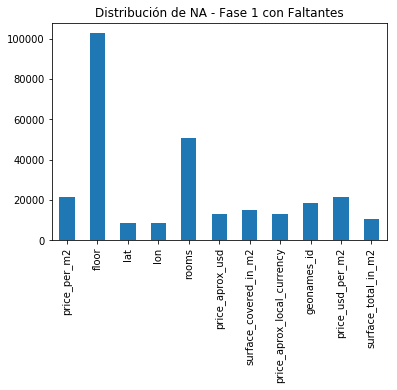

In [28]:
freqna['total'].plot.bar(title='Distribución de NA - Fase 1 con Faltantes')

In [29]:
new_columns = {
    'surface_total_in_m2'       : 'superficie_total', #7
    'surface_covered_in_m2'     : 'superficie_cubierta', #10
    'price_aprox_local_currency': 'precio_ars', #13
    'price_aprox_usd'           : 'precio_usd', #6
    'price_per_m2'              : 'precio_m2_ars', #3
    'price_usd_per_m2'          : 'precio_m2_usd', #12
    'rooms'                     : 'ambientes', #15
    'lon'                       : 'lng', #14
    'floor'                     : 'piso', #5
    'geonames_id'               : 'geoid', #0
    'place_name'                : 'localidad', #11
    'state_name'                : 'estado', #4
    'country_name'              : 'pais', #1
    'property_type'             : 'tipo', #8
    'operation'                 : 'op', #2
    #'lat'                      : 'lat', #9
}

data.rename(columns=new_columns, inplace=True)

new_order = [6,11, 0, 17, 18, 19, 13, 1, 21, 2, 10, 20, 9, 16, 12, 14,7,15,22,8]
data = data[data.columns[new_order]]
#print(data.columns)
data.head(5)


,pais,precio_usd,precio_m2_ars,precio_ars,geoid,precio_m2_usd,balcon,quincho,superficie_total,localidad,ambientes,piscina,op,estado,parrilla,tipo,lat,superficie_cubierta,patio,lng
3577.0,Argentina,62000.0,1550.000000,1093959.0,3430787.0,1127.272727,0,0,55.0,Mataderos,2.0,0,sell,Capital Federal,0,PH,-34.661824,40.0,1,-58.508839
4827.0,Argentina,150000.0,NaN,2646675.0,3432039.0,NaN,1,0,NaN,La Plata,NaN,0,sell,Bs.As. G.B.A. Zona Sur,0,apartment,-34.903883,NaN,0,-57.964330
3577.0,Argentina,72000.0,1309.090909,1270404.0,3430787.0,1309.090909,0,0,55.0,Mataderos,2.0,0,sell,Capital Federal,0,apartment,-34.652262,55.0,0,-58.522982
4122.0,Argentina,95000.0,NaN,1676227.5,3431333.0,NaN,0,0,NaN,Liniers,3.0,0,sell,Capital Federal,0,PH,-34.647797,NaN,1,-58.516424
NaN,Argentina,64000.0,1828.571429,1129248.0,3435548.0,1828.571429,0,0,35.0,Centro,2.0,0,sell,Buenos Aires Costa Atlántica,0,apartment,-38.002626,35.0,0,-57.549447


In [30]:
# Variables con escala logaritmica para los precios
data['precio_ars_log']    = np.log(data['precio_ars'] + 1)
data['precio_m2_ars_log'] = np.log(data['precio_m2_ars'] + 1)
data['precio_usd_log']    = np.log(data['precio_usd'] + 1)
data['precio_m2_usd_log'] = np.log(data['precio_m2_usd'] + 1)

In [31]:
data.head(5)

,pais,precio_usd,precio_m2_ars,precio_ars,geoid,precio_m2_usd,balcon,quincho,superficie_total,localidad,...,parrilla,tipo,lat,superficie_cubierta,patio,lng,precio_ars_log,precio_m2_ars_log,precio_usd_log,precio_m2_usd_log
3577.0,Argentina,62000.0,1550.000000,1093959.0,3430787.0,1127.272727,0,0,55.0,Mataderos,...,0,PH,-34.661824,40.0,1,-58.508839,13.905315,7.346655,11.034906,7.028443
4827.0,Argentina,150000.0,NaN,2646675.0,3432039.0,NaN,1,0,NaN,La Plata,...,0,apartment,-34.903883,NaN,0,-57.964330,14.788815,NaN,11.918397,NaN
3577.0,Argentina,72000.0,1309.090909,1270404.0,3430787.0,1309.090909,0,0,55.0,Mataderos,...,0,apartment,-34.652262,55.0,0,-58.522982,14.054846,7.177852,11.184435,7.177852
4122.0,Argentina,95000.0,NaN,1676227.5,3431333.0,NaN,0,0,NaN,Liniers,...,0,PH,-34.647797,NaN,1,-58.516424,14.332057,NaN,11.461643,NaN
NaN,Argentina,64000.0,1828.571429,1129248.0,3435548.0,1828.571429,0,0,35.0,Centro,...,0,apartment,-38.002626,35.0,0,-57.549447,13.937063,7.511837,11.066654,7.511837


Aplicacion de distancias al subte... por ahora para x cantidad de registros, por tiempo de proceso

In [63]:
def haversine(Olat,Olon, Dlat,Dlon):

    radius = 6371.  # km

    d_lat = np.radians(Dlat - Olat)
    d_lon = np.radians(Dlon - Olon)
    a = (np.sin(d_lat / 2.) * np.sin(d_lat / 2.) +
         np.cos(np.radians(Olat)) * np.cos(np.radians(Dlat)) *
         np.sin(d_lon / 2.) * np.sin(d_lon / 2.))
    c = 2. * np.arctan2(np.sqrt(a), np.sqrt(1. - a))
    d = radius * c
    return d
def searchClosestSubDistance(dataSubte,lat,long):
    dataSubte['dist'] = dataSubte.apply(lambda x: haversine(x['lat'], x['long'],lat,long), axis=1)
    return dataSubte['dist'].min()#dist



In [64]:
dataSubte     = pd.read_csv("./data/estaciones-de-subte.csv", sep = ",", low_memory=False)
#dataSubte.head()
#dataSubte.loc[[1], ['estacion']]
mask = (pd.notnull(data.lat)) & (pd.notnull(data.lng)) & (data.estado == 'Capital Federal') 
print(data[mask].size) 
data2 = data[mask].head(5000)
#data2.head()

#ind = dataSubte['long'].argmin()
#print(dataSubte.loc[[ind], ['long']])
#print(dataSubte['long'].min())
#data['distsubte'].head()

760728


In [65]:
data2['dist'] = data2.apply(lambda x:  searchClosestSubDistance(dataSubte,x['lat'],x['lng']), axis=1)
#data2['dist'] = data2.apply(lambda x:  1, axis=1)
data2.head()

,pais,precio_usd,precio_m2_ars,precio_ars,geoid,precio_m2_usd,balcon,quincho,superficie_total,localidad,...,tipo,lat,superficie_cubierta,patio,lng,precio_ars_log,precio_m2_ars_log,precio_usd_log,precio_m2_usd_log,dist
3577.0,Argentina,62000.0,1550.000000,1093959.0,3430787.0,1127.272727,0,0,55.0,Mataderos,...,PH,-34.661824,40.0,1,-58.508839,13.905315,7.346655,11.034906,7.028443,4.781915
3577.0,Argentina,72000.0,1309.090909,1270404.0,3430787.0,1309.090909,0,0,55.0,Mataderos,...,apartment,-34.652262,55.0,0,-58.522982,14.054846,7.177852,11.184435,7.177852,5.436760
4122.0,Argentina,95000.0,NaN,1676227.5,3431333.0,NaN,0,0,NaN,Liniers,...,PH,-34.647797,NaN,1,-58.516424,14.332057,NaN,11.461643,NaN,4.683008
8852.0,Argentina,138000.0,3450.000000,2434941.0,3436077.0,3066.666667,0,0,45.0,Belgrano,...,apartment,-34.559873,40.0,0,-58.443362,14.705433,8.146419,11.835016,8.028673,1.068329
8852.0,Argentina,195000.0,3250.000000,3440677.5,3436077.0,3000.000000,0,0,65.0,Belgrano,...,apartment,-34.559873,60.0,0,-58.443362,15.051179,8.086718,12.180760,8.006701,1.068329


In [ ]:
mask_graph = data.precio_m2_usd < 3500
sns.pairplot(data[mask_graph], vars = ['precio_m2_usd_log','precio_usd_log','amenities'], height=2.5);